In [ ]:
# 추천 아티스트 + 메타데이터 합치기
# 아티스트 이름/장르/트랙 정보 붙이기

# 결과: test_reranked_topk_a05.csv 안에 user_id, artist_id, final_score(als+리랭커), 아티스트 이름/장르 등이 들어가게 됨

import pandas as pd

recs = pd.read_csv("/content/drive/MyDrive/data/test_reranked_topk_a05.csv")
artists = pd.read_csv("/content/drive/MyDrive/data/spotify/artists.csv")

# artists의 id → artist_id로 이름 변경
artists = artists.rename(columns={"id": "artist_id"})

# 타입 통일 (둘 다 문자열)
recs["artist_id"] = recs["artist_id"].astype(str)
artists["artist_id"] = artists["artist_id"].astype(str)

# merge
recs_merged = recs.merge(artists, on="artist_id", how="left")
recs_merged.head()

,user_id,artist_id,final_score,ranker_score,als_score,followers,genres,name,popularity
0,0,929,0.449040,-0.021184,0.919265,NaN,NaN,NaN,NaN
1,0,1102,0.064761,0.104657,0.024865,NaN,NaN,NaN,NaN
2,0,752,0.064751,0.104657,0.024845,NaN,NaN,NaN,NaN
3,0,5408,0.064745,0.104657,0.024832,NaN,NaN,NaN,NaN
4,0,4656,0.064742,0.104657,0.024828,NaN,NaN,NaN,NaN


In [ ]:
# artist_id 컬럼이 두 데이터프레임 모두 문자열(object) 타입으로 맞춰졌는지 확인
recs["artist_id"].dtype, artists["artist_id"].dtype

(dtype('O'), dtype('O'))

# 이런식으로 merge


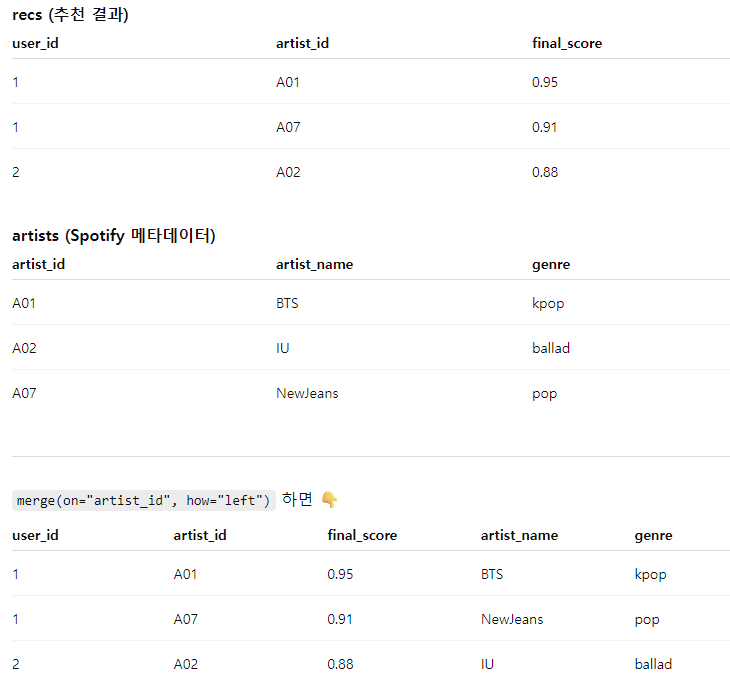

In [ ]:
print(artists.columns) # 결론: artist column에 tempo, valence 같은게 없어서 track 파일에서 불러와야함

Index(['artist_id', 'followers', 'genres', 'name', 'popularity'], dtype='object')


In [ ]:
# 유저 취향 벡터 계산 (genre/tempo/valence 등)
# 이 유저는 어떤 스타일을 좋아하는지 수치로 만들기

import pandas as pd
import numpy as np
import ast

# 데이터 로드
artists = pd.read_csv("/content/drive/MyDrive/data/spotify/artists.csv")
tracks  = pd.read_csv("/content/drive/MyDrive/data/spotify/tracks.csv")


# artists: id -> artist_id
if "artist_id" not in artists.columns and "id" in artists.columns:
    artists = artists.rename(columns={"id": "artist_id"})

artists["artist_id"] = artists["artist_id"].astype(str)

# tracks: id_artists에서 artist_id 추출 (첫 번째 아티스트 사용)
tracks["artist_id"] = tracks["id_artists"].apply(
    lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith("[") else None
)
tracks["artist_id"] = tracks["artist_id"].astype(str)

# tracks에서 사용할 피처만 뽑아서 artist 단위 평균
use_cols = ["artist_id"]
for c in ["tempo", "valence"]:
    if c in tracks.columns:
        use_cols.append(c)

artist_audio = (
    tracks[use_cols]
    .groupby("artist_id")
    .mean()
    .reset_index()
)

# artists + audio 피처 합친게 'artists_full'
artists_full = artists.merge(artist_audio, on="artist_id", how="left")

# 여기! ALS train 말고 join 결과 사용
joined = pd.read_csv("/content/drive/MyDrive/data/derived/lastfm_join_strict/joined.csv")
# joined 안의 artist_id는 이미 Spotify id일 것

# logs에 artists_full 붙이기 (여기서 artists 말고 artists_full 써야 함)
logs_full = joined.merge(artists_full, on="artist_id", how="left")

# 유저별 평균 tempo/valence 계산
agg = {}
if "tempo" in logs_full.columns:
    agg["mean_tempo"] = ("tempo", "mean")
if "valence" in logs_full.columns:
    agg["mean_valence"] = ("valence", "mean")

user_pref = logs_full.groupby("Username").agg(**agg).reset_index()
user_pref.head()


,Username,mean_tempo,mean_valence
0,Babs_05,121.213323,0.505715
1,Knapster01,120.721318,0.495887
2,Orlenay,120.234856,0.509081
3,eartle,120.711678,0.505015
4,franhale,121.520856,0.497864


In [ ]:
import pandas as pd
import ast

# 추천 결과
recs = pd.read_csv("/content/drive/MyDrive/data/test_reranked_topk_a05.csv")

# ALS artist_id -> 실제 아티스트 정보 매핑
amap = pd.read_csv("/content/drive/MyDrive/data/derived/als/artist_mapping.csv")

# Artist 컬럼을 artist_name으로 통일
# Artist -> artist_mapping 파일 안에 있는 아티스트 이름 column
# artist_name -> 우리가 일관되게 쓸 이름 (이걸로 track 매칭할거임)
amap_use = amap[["artist_id", "Artist"]].rename(columns={"Artist": "artist_name"})

# 타입 맞추고 merge
recs["artist_id"] = recs["artist_id"].astype(int)
amap_use["artist_id"] = amap_use["artist_id"].astype(int)

recs = recs.merge(amap_use, on="artist_id", how="left")

print(recs.head()) # 리랭커 + ALS 블렌딩 결과에 실제 아티스트 이름까지 붙은 상태

   user_id  artist_id  final_score  ranker_score  als_score      artist_name
0        0        929     0.449040     -0.021184   0.919265            Bicep
1        0       1102     0.064761      0.104657   0.024865        Bob Dylan
2        0        752     0.064751      0.104657   0.024845  Badly Drawn Boy
3        0       5408     0.064745      0.104657   0.024832         Maroon 5
4        0       4656     0.064742      0.104657   0.024828             Kygo


In [ ]:
import pandas as pd
import ast

tracks = pd.read_csv("/content/drive/MyDrive/data/spotify/tracks.csv")
tracks.head()


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [ ]:
# 후보 아티스트 -> 트랙 매핑 (각 아티스트 인기 트랙 N곡)
# 아티스트 이름으로 트랙 찾는 함수
# 예시) artist_name = "Bicep" 들어오면 tracks에서 artists 문자열에 "Bicep" 들어간 트랙 상위 2개 줌

def pick_tracks_for_artist(artist_name, n=2):
    # artist_name이 비어있으면 스킵
    if not isinstance(artist_name, str) or artist_name.strip() == "":
        return tracks.iloc[0:0]

    # artists 컬럼 문자열 안에 artist_name이 들어가는 트랙만 선택
    cand = tracks[tracks["artists"].str.contains(artist_name, case=False, na=False)].copy()

    if cand.empty:
        return cand

    # popularity 있으면 인기순 정렬
    if "popularity" in cand.columns:
        cand = cand.sort_values("popularity", ascending=False)

    # 상위 n곡 반환
    return cand.head(n)

In [ ]:
# recs에서 유저별 트랙 후보 만들기
# cand_tracks: user_id 별 여러 트랙 후보 리스트

rows = []

for _, r in recs.iterrows():
    artist_name = r["artist_name"]
    base = r["final_score"]

    uts = pick_tracks_for_artist(artist_name, n=2)

    for _, t in uts.iterrows():
        rows.append({
            "user_id": r["user_id"],
            "artist_name": artist_name,
            "track_id": t.get("id"),
            "track_name": t.get("name"),
            "tempo": t.get("tempo"),
            "valence": t.get("valence"),
            "popularity": t.get("popularity"),
            "base_score": base
        })

cand_tracks = pd.DataFrame(rows)
print(cand_tracks.head())
print("cand_tracks shape:", cand_tracks.shape) # 결론: 여기까지 실행해서 cand_tracks 행이 318개 정도로 나왔으므로 성공

# cand_tracks 파일로 저장
save_path = "/content/drive/MyDrive/data/derived/recommendation/cand_tracks.csv"

# 폴더 없으면 자동 생성
import os
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# CSV로 저장 (한글, 숫자, UTF-8 완전 대응)
cand_tracks.to_csv(save_path, index=False, encoding="utf-8-sig")


   user_id      artist_name                track_id  \
0        0            Bicep  2aJDlirz6v2a4HREki98cP   
1        0            Bicep  73X9X7kDgsm4YeHpc8prf6   
2        0        Bob Dylan  3AhXZa8sUQht0UEdBJgpGc   
3        0        Bob Dylan  6HSXNV0b4M4cLJ7ljgVVeh   
4        0  Badly Drawn Boy  2TnNFFgZhaBzEEobxDy5uV   

                  track_name    tempo  valence  popularity  base_score  
0                       Glue  129.983    0.420          72    0.449040  
1                   Apricots  127.986    0.489          68    0.449040  
2       Like a Rolling Stone   95.261    0.562          75    0.064761  
3  Knockin' On Heaven's Door  140.208    0.229          74    0.064761  
4      Once Around the Block  115.744    0.859          52    0.064751  
cand_tracks shape: (318, 8)


In [ ]:
# 유저별로 같은 트랙이 여러번 들어갔으면 정리하기

cand_tracks = (
    cand_tracks
    .sort_values(["user_id", "base_score", "popularity"], ascending=[True, False, False])
    .drop_duplicates(["user_id", "track_id"])
    .reset_index(drop=True)
)

In [ ]:
# 유저별 추천 곡 수
cand_tracks['user_id'].value_counts().sort_index()

,count
user_id,
0,30
1,30
2,29
3,30
4,27
5,28
6,30
7,28
8,29


In [ ]:
# user mapping 불러오기
user_map = pd.read_csv("/content/drive/MyDrive/data/derived/als/user_mapping.csv")

# Username 기준으로 join → user_id 붙이기
user_pref_uid = user_pref.merge(user_map, on="Username", how="inner")

# 필요한 컬럼만 남기기
user_pref_uid = user_pref_uid[["user_id", "mean_tempo", "mean_valence"]]

# cand_tracks와 user_id 기준 병합
cand_tracks = cand_tracks.merge(user_pref_uid, on="user_id", how="left")

# 확인
cand_tracks[["user_id", "mean_tempo", "mean_valence"]].head()

,user_id,mean_tempo,mean_valence
0,0,121.213323,0.505715
1,0,121.213323,0.505715
2,0,121.213323,0.505715
3,0,121.213323,0.505715
4,0,121.213323,0.505715


In [ ]:
# 혹시 공백 붙어있을까봐 정리
cand_tracks.columns = cand_tracks.columns.str.strip()
user_pref.columns = user_pref.columns.str.strip()

print("cand_tracks:", cand_tracks.columns.tolist())
print("user_pref:", user_pref.columns.tolist())

cand_tracks: ['user_id', 'artist_name', 'track_id', 'track_name', 'tempo', 'valence', 'popularity', 'base_score', 'mean_tempo', 'mean_valence']
user_pref: ['Username', 'mean_tempo', 'mean_valence']


In [ ]:
# 최종 점수 설계 (가중 평균 점수)

# 예시)
# base_score(0.6): 모델(ALS + 리랭커)이 준 기본 선호 점
# tempo_sim(0.2), valence_sim(0.2): 유저 취향과 곡 feature의 유사도 (0~1)
# final_playlist_score: 위 셋을 0.6, 0.2, 0.2 가중평균한 최종 점


import numpy as np
import pandas as pd

def sim(x, mu, max_diff):
    if pd.isna(x) or pd.isna(mu):
        return 0.5  # 정보 없으면 중간값
    diff = abs(x - mu)
    return max(0.0, 1.0 - diff / max_diff)

cand_tracks["tempo_sim"] = cand_tracks.apply(
    lambda r: sim(r["tempo"], r["mean_tempo"], 80), axis=1
)
cand_tracks["valence_sim"] = cand_tracks.apply(
    lambda r: sim(r["valence"], r["mean_valence"], 1.0), axis=1
)

# 가중 평균 기반 최종 점수 계산
w_base, w_tempo, w_val = 0.6, 0.2, 0.2

cand_tracks["final_playlist_score"] = (
    w_base * cand_tracks["base_score"]
    + w_tempo * cand_tracks["tempo_sim"]
    + w_val * cand_tracks["valence_sim"]
)

cand_tracks[["track_name", "artist_name", "final_playlist_score"]].head(10)


# 결론: 이 점수 -> 이 유저에게 이 트랙이 어울리는 정도를 나타냄
# 이 코드는 user0의 개인화 플레이리스트 추천 결과

,track_name,artist_name,final_playlist_score
0,Glue,Bicep,0.630357
1,Apricots,Bicep,0.649150
2,Like a Rolling Stone,Bob Dylan,0.362719
3,Knockin' On Heaven's Door,Bob Dylan,0.336027
4,Once Around the Block,Badly Drawn Boy,0.354520
5,Something To Talk About,Badly Drawn Boy,0.432310
6,Beautiful Mistakes (feat. Megan Thee Stallion),Maroon 5,0.340377
7,Memories,Maroon 5,0.349504
8,Higher Love,Kygo,0.375349
9,Lose Somebody,Kygo,0.371652


**궁금증** --> tempo, valence 말고도 다른 피쳐들이 많은데 다 만들어놔야되는건가?


**답변** --> 모든 피쳐를 다 만드는게 아니라 의미있는 피쳐만 선택적으로 쓰면됨. ALS/리랭커가 이미 선호도를 학습했기 때문에 메타 피쳐는 감성적/분위기적 조정 용도로만 사용!

In [ ]:
# 유저별 플레이리스트 만들기
PLAYLIST_LEN = 10  # 유저당 10곡 추천

playlists = []

for uid, g in cand_tracks.groupby("user_id"):
    # 점수 높은 순으로 정렬
    g = g.sort_values("final_playlist_score", ascending=False)
    # 같은 트랙 중복 추천 방지
    g = g.drop_duplicates("track_id")
    # 상위 N곡만
    g = g.head(PLAYLIST_LEN).copy()
    # 랭킹 컬럼 추가
    g["rank_in_playlist"] = range(1, len(g) + 1)
    playlists.append(g)

playlist_df = pd.concat(playlists, ignore_index=True)

# 확인: user5의 플레이리스트
playlist_df[playlist_df["user_id"] == 5][
    ["rank_in_playlist", "track_name", "artist_name", "final_playlist_score"]
].head(PLAYLIST_LEN)


,rank_in_playlist,track_name,artist_name,final_playlist_score
50,1,Faster,Within Temptation,0.665690
51,2,All I Need,Within Temptation,0.530631
52,3,Lasting Lover,Gala,0.422688
53,4,The Hand That Feeds,Nine Inch Nails,0.416928
54,5,Kyoto,Phoebe Bridgers,0.407912
55,6,Radioactive,Lindsey Stirling,0.403984
56,7,Dandelion,Gala,0.393258
57,8,Blind Faith,Chase & Status,0.380817
58,9,"Twinkle, Twinkle, Little Star",Nursery Rhymes ABC,0.369130
59,10,Motion Sickness,Phoebe Bridgers,0.367399


상황별 플리 짜는건.. cand_tracks에 final_playlist_score, tempo, valence 있으니까 거기에 상황별 가중치만 다르게 주는 방식으로 가면 될듯

1) workout : 빠르고 밝고 에너지 넘치는
2) study : 너무 빠르지 않고 너무 밝지도 어둡지도 않은
3) walk : 극단적이지 않고 적당히 밝고 가벼운
4) chill : 차분한

In [ ]:
# gui 이용한 플레이리스트
# 터미널로 해야됨

import streamlit as st
import pandas as pd

cand_tracks = pd.read_csv("C:\\Users\\hyeri\\work\\MLtermproject\\cand_tracks.csv")
user_map = pd.read_csv("C:\\Users\hyeri\\work\\MLtermproject\\user_mapping.csv")

# final_playlist_score 없으면 base_score로 채우기
if "final_playlist_score" not in cand_tracks.columns:
    cand_tracks["final_playlist_score"] = cand_tracks["base_score"]

# 플레이리스트 부분
def build_context_playlist(cand_tracks, user_id, n=20, mode="default"):
    pl = cand_tracks[cand_tracks["user_id"] == user_id].copy()
    if pl.empty:
        st.warning("There are no recommendation candidates for this user.")
        return pd.DataFrame()

    pl["tempo"] = pd.to_numeric(pl["tempo"], errors="coerce")
    pl["valence"] = pd.to_numeric(pl["valence"], errors="coerce")

    base = pl["final_playlist_score"]

    if mode == "workout":
        tempo_norm   = ((pl["tempo"] - 120) / 60).clip(0, 1)
        valence_norm = ((pl["valence"] - 0.5) / 0.5).clip(0, 1)
        score = 0.4 * base + 0.4 * tempo_norm + 0.2 * valence_norm
    elif mode == "study":
        tempo_center = 100
        tempo_norm = (1 - (abs(pl["tempo"] - tempo_center) / 40)).clip(0, 1)
        valence_center = 0.4
        valence_norm = (1 - (abs(pl["valence"] - valence_center) / 0.4)).clip(0, 1)
        score = 0.6 * base + 0.25 * tempo_norm + 0.15 * valence_norm
    elif mode == "walk":
        tempo_norm = ((pl["tempo"] - 90) / 40).clip(0, 1)
        valence_norm = ((pl["valence"] - 0.4) / 0.4).clip(0, 1)
        score = 0.5 * base + 0.3 * tempo_norm + 0.2 * valence_norm
    elif mode == "chill":
        tempo_center = 80
        tempo_norm = (1 - (abs(pl["tempo"] - tempo_center) / 40)).clip(0, 1)
        valence_center = 0.35
        valence_norm = (1 - (abs(pl["valence"] - valence_center) / 0.35)).clip(0, 1)
        score = 0.5 * base + 0.3 * tempo_norm + 0.2 * valence_norm
    else:
        score = base

    pl[f"{mode}_score"] = score
    pl = pl.sort_values(f"{mode}_score", ascending=False).drop_duplicates("track_id").head(n)
    pl["rank"] = range(1, len(pl) + 1)
    return pl[["rank", "track_name", "artist_name", f"{mode}_score"]]


def app(cand_tracks, user_map):
    st.title("🎧 Personalized Playlist Generator")

    username = st.text_input("Please enter your name")
    mode = st.selectbox("Please select a situation", ["default", "workout", "study", "walk", "chill"])
    n = st.slider("Number of recommended songs", 5, 20, 10)

    if st.button("Create Playlist"):
        if username.strip() == "":
            st.warning("Please enter Username.")
            return

        row = user_map[user_map["Username"] == username]
        if row.empty:
            st.error(f"'{username}' not found.")
            return

        user_id = int(row["user_id"].iloc[0])
        playlist = build_context_playlist(cand_tracks, user_id, n=n, mode=mode)

        if playlist.empty:
            st.info("There is no recommendation results.")
        else:
            st.success(f"{mode} Playlist for {username}")
            st.dataframe(playlist, use_container_width=True)



app(cand_tracks, user_map)